<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/17.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_residencial.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos individuais - reformulação da implementação](16.00.Aula-Modelos_individuais_reformulacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário de múltiplos do Pop350: redes sociais ->](18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.ipynb)

---


# Construção de cenários: definindo as idades

- O objetivo, aqui, é definir as idades de cada indivíduo da população.

- Isso será feito após a alocação dos indivíduos em residências.

- Como exemplo, vamos usar a rede de residências de uma fração da população do Rio de Janeiro.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy.stats import zipf

import networkx as nx

from numba import jit, njit, prange
from numba.typed import List
import threading # for multi-threading with numba.jit

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 08/Jun/2020


## Distribuição espacial da população da cidade do Rio de Janeiro

### Carregando os dados

Os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro foram obtidos pelo [Landscan](https://landscan.ornl.gov).

Como feito anteriormente, após carregarmos os dados, zeramos os valores das células com -1, que indicam falta de informação.

In [5]:
landscan_rio = np.maximum(np.load('../input/dados_rio/landscan_rio.npy').astype(int), 0)

### Reduzindo a população para testes

Na montagem do cenário, com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator.

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [6]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 67973


### Visualização da distribuição populacional em escala logarítmica

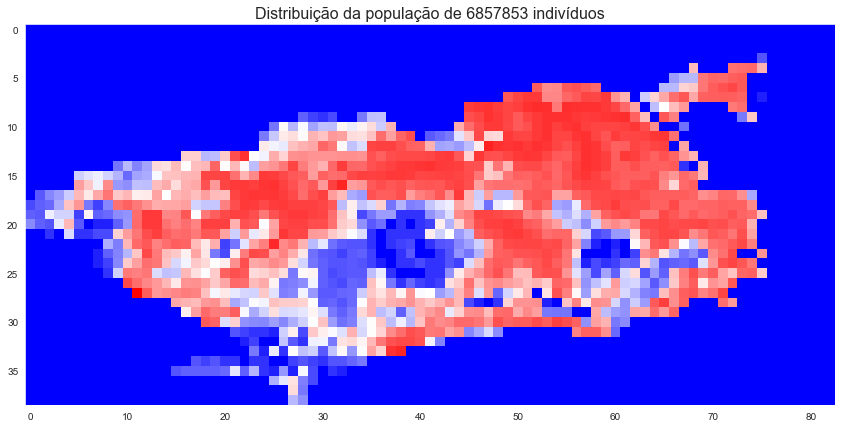

In [7]:
plt.figure(figsize=(15,7))
plt.imshow(np.log(1 + landscan_rio), cmap='bwr', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

### Censo residencial

A distribuição da população em residências é feita segundo um censo com a porcentagem de residências por número de residentes:

In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])

### Distribuindo e alocando os indivíduos e as suas residências

In [9]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 877 ms, sys: 29.1 ms, total: 906 ms
Wall time: 972 ms


### Distribuição por tamanho de residência

In [10]:
num_tam_res = len(censo_residencial)
distrib_tam_por_res = np.array([len(res_individuos[k]) for k in range(len(res_individuos))])
distrib_res = np.array([len(distrib_tam_por_res[distrib_tam_por_res == j]) for j in range(1,num_tam_res+1)])

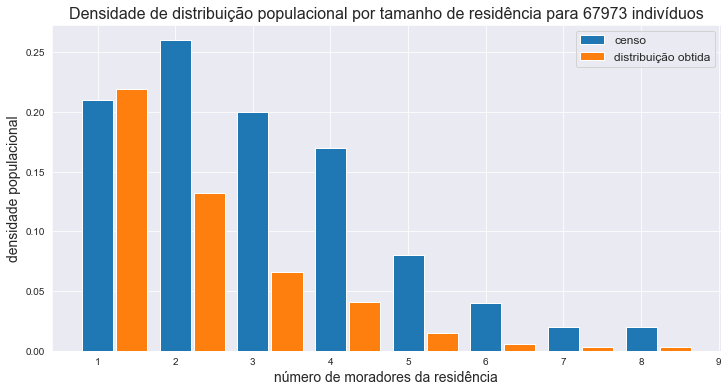

In [11]:
plt.figure(figsize=(12,6))
bar_width = 0.4
r1 = [j for j in range(1,num_tam_res+1)]
r2 = [j + 1.1*bar_width for j in range(1,num_tam_res+1)]
plt.bar(r1, censo_residencial, width=bar_width, label='censo')
plt.bar(r2, distrib_res/num_pop, width=bar_width, label=f'distribuição obtida')
plt.xlabel('número de moradores da residência', fontsize=14)
plt.ylabel('densidade populacional', fontsize=14)
plt.legend(fontsize=12)
plt.title(f'Densidade de distribuição populacional por tamanho de residência para {num_pop} indivíduos',
          fontsize=16)
plt.show()  

## Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela 6407 do IBGE - População residente, por sexo e grupo de idade](https://sidra.ibge.gov.br/tabela/6407#resultado), que infelizemente não diferencia faixas acima de 65 anos:


| Total | 100,0 |
| --- | --- |
| 0 a 4 anos | 9,4 |
| 5 a 9 anos | 11,9 |
| 10 a 13 anos | 13,2 |
| 14 a 17 anos | 15,5 |
| 18 e 19 anos | 14,2 |
| 20 a 24 anos | 14,0 |
| 25 a 29 | 22,0 |
| 30 a 39 anos | 15,5 |
| 40 a 49 anos | 14,2 |
| 50 a 59 anos | 14,0 |
| 60 a 64 anos | 14,0 |
| 65 ou mais | 22,0 |



###  Tabelando os dados disponíveis

Primeiramente montamos duas listas, umas com as faixas etárias e outra com a fração da população em cada faixa.

In [12]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100
print(f'Conferindo a soma das frações dos grupos de idades: {idades_fracoes_grupos.sum()}')

Conferindo a soma das frações dos grupos de idades: 1.0


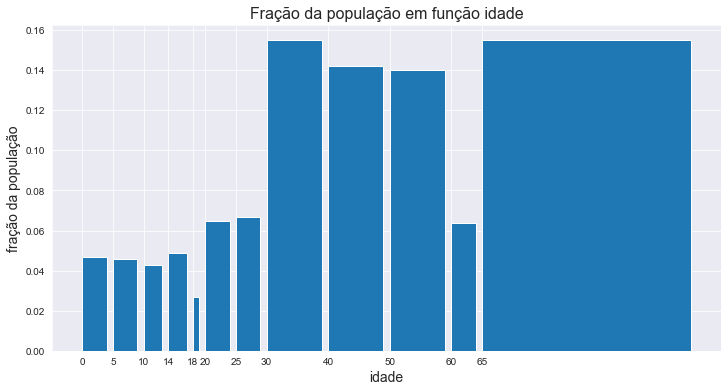

In [13]:
plt.figure(figsize=(12,6))
bar_width = [idades_grupos[j+1] - idades_grupos[j] - 1 for j in range(len(idades_grupos)-1)] \
            + [idade_max - idades_grupos[-1] -1]
plt.bar(idades_grupos, idades_fracoes_grupos, width=bar_width, align='edge')
plt.xticks(idades_grupos)
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Fração da população em função idade', fontsize=16)
plt.show()

### Interpolando e extrapolando os dados

Agora, interpolamos os dados para ter frações para cada idade na faixas acima e extrapolamos no caso da última faixa.

Vou fazer uma interpolação/extrapolação simples, de maneira constante por partes, mas podemos melhorar isso, principalmente usando o número de nascidos na faixa de 0 a 1 ano e frações para idades maiores.

In [14]:
idades_fracoes = list()
for j in range(len(idades_grupos)-1):
    idades_fracoes += (idades_grupos[j+1] - idades_grupos[j]) \
        * [idades_fracoes_grupos[j]/(idades_grupos[j+1]-idades_grupos[j])]

idades_fracoes += (idade_max - idades_grupos[-1]) \
        * [idades_fracoes_grupos[-1]/(idade_max-idades_grupos[-1])]

idades_fracoes = np.array(idades_fracoes)
print(idades_fracoes.sum())

1.0000000000000002


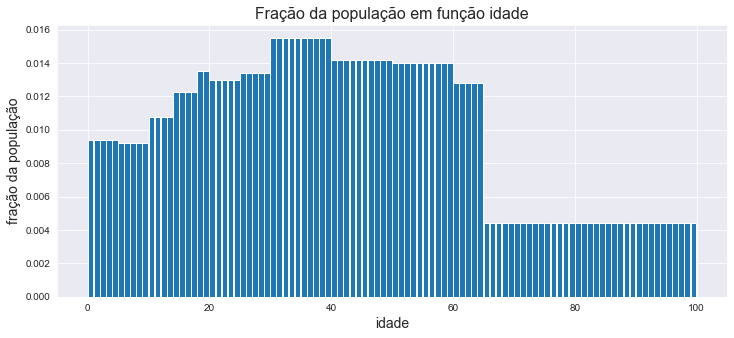

In [15]:
plt.figure(figsize=(12,5))
plt.bar(range(len(idades_fracoes)), idades_fracoes, width=0.95, align='edge')
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Fração da população em função idade', fontsize=16)
plt.show()

## Distribuição das idades dos indivíduos

- A estratégia é usar os dados da pirâmide populacional do Rio de Janeiro como pesos nas escolhas das idades dos indivíduos.

- Vamos fazer por partes, percorrendo as residências por tamanho e sorteando as idades dos residentes;

    - Nas casas com um único indivíduo, sorteamos um adulto (20 anos para cima), com pesos proporcionais as faixas de 20 pra cima.
    
    - Nas casas com dois indivíduos, sorteamos 90% deles com dois adultos e 10% deles com um adulto e uma criança
    
    - Nas casas com mais de dois indivíduos, sorteamos dois adultos e o restante de qualquer idade
    
    - A cada passo, atualizamos a população restante para obter novos pesos.

### Distribuindo as idades

- Primeiro, consideramos a população em idade ativa.

- De acordo com o IBGE, a população em idade ativa é formada pelos indivíduos com 16 ou mais anos de idade.

- Segundo, consideramos a parte economicamente ativa, que são os, de fato, trabalhando de alguma forma. Nesse caso:

    - Boa parte dos que têm até 17 ou 18 anos ainda está no ensino médio.

    - Uma certa parte dos que têm em torno de vinte anos está na faculdade.
    
    - Boa parte dos que têm 60 anos ou mais está aposentada.
    
    - Uma parte razoável dos outros está desocupada.
    

- Na falta de dados concretos, vou assumir certas frações das populações dessas idades como estando economicamente ativas, para serem alocadas nos locais de trabalho.

### Separa as residências por tamanho

In [16]:
%%time
res = (num_tam_res+1)*[[]]
for j in range(1,num_tam_res+1):
    res[j] = [r for r in res_individuos if len(r) == j]
res_2b = random.sample(res[2], k=int(0.1*len(res[2])))
res_2a = [r for r in res[2] if r not in res_2b]
res_3mais = []
for res_k in res[3:]:
    res_3mais += res_k

CPU times: user 481 ms, sys: 9.37 ms, total: 490 ms
Wall time: 519 ms


### Separa a piramide populacional em crianças/jovens e adultos

As distribuições são apenas para definir os pesos para as escolhas das idades, não sendo estritamente necessário transformá-los em inteiros cuja soma dê exatamente a população total.

In [17]:
idades = list(range(len(idades_fracoes)))

distrib_idades_adultos = num_pop*idades_fracoes
distrib_idades_adultos[:20] = 0

distrib_idades_menores = num_pop*idades_fracoes
distrib_idades_menores[20:] = 0

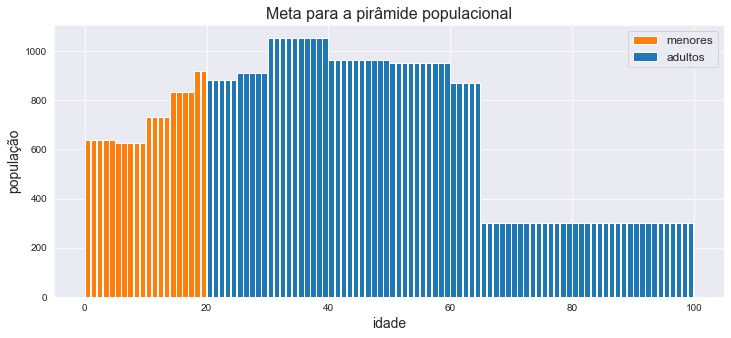

In [18]:
plt.figure(figsize=(12,5))
plt.bar(range(len(distrib_idades_menores)), distrib_idades_menores,
        width=0.9, align='edge', color='tab:orange', label='menores')
plt.bar(range(len(distrib_idades_adultos)), distrib_idades_adultos,
        width=0.9, align='edge', color='tab:blue', label='adultos')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title('Meta para a pirâmide populacional', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Inicializa a lista de idades dos indivíduos

In [19]:
pop_idades = np.zeros(num_pop).astype(int)
n = 0

In [20]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 0
Distribuição de indivíduos em função da idade:
[67973     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


### Define a idade dos adultos morando sozinhos

Colocamos um adulto nas residências que contém apenas um indivíduo.

In [21]:
%%time
random.seed(17000001)

ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res[1]))
for j in range(len(res[1])):
    pop_idades[res[1][j]] = ind_idades[j]
    distrib_idades_adultos[ind_idades[j]] -= 1
n += len(res[1])
print(len(res[1]))
print(n)

14908
14908
CPU times: user 59.1 ms, sys: 1.64 ms, total: 60.7 ms
Wall time: 59.8 ms


In [22]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 14908
Distribuição de indivíduos em função da idade:
[53065     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   244   236   244   230
   241   255   242   265   245   245   293   307   310   277   277   307
   287   281   309   311   253   251   281   268   276   277   309   265
   269   283   279   300   261   229   252   275   275   273   253   257
   246   249   237   234   241    72    83    85    86    66    77    95
    96    83    97    73    69    67    81    90    80    71    81    86
    95    78    75    77    89   105   105    86   103    93    93    68
    62    85    87    70]


### Define a idade do único adulto em residências com um adulto e um menor

In [23]:
%%time
random.seed(27000002)

ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res_2b))
for j in range(len(res_2b)):
    pop_idades[res_2b[j][0]] = ind_idades[j]
    distrib_idades_adultos[ind_idades[j]] -= 1
n += len(res_2b)
print(len(res_2b))
print(n)

895
15803
CPU times: user 2.64 ms, sys: 101 µs, total: 2.74 ms
Wall time: 2.68 ms


In [24]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 15803
Distribuição de indivíduos em função da idade:
[52170     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   265   247   263   251
   251   267   264   277   263   260   315   327   327   299   295   323
   312   297   324   327   274   265   299   290   287   291   327   279
   281   297   291   319   277   247   272   293   287   291   268   266
   263   261   249   249   251    74    90    91    90    71    87   103
   102    90   103    77    71    75    84    95    84    78    84    92
    97    84    77    83    91   107   112    89   106    96    96    71
    65    92    93    75]


### Define a idade de dois adultos nas outras residências com dois indivíduos

- Nas residêcias com apenas dois indivíduos, já colocamos, anteriormente, um adulto nas residências com uma adulto e um menor. Agora, colocamos dois adultos no restante das residências com dois indivíduos.

In [25]:
%%time
random.seed(37010203)
len_res_2a = len(res_2a)
ind_idades = random.choices(idades, distrib_idades_adultos, k=2*len_res_2a)
for j in range(len_res_2a):
    pop_idades[res_2a[j][0]] = ind_idades[j]
    pop_idades[res_2a[j][1]] = ind_idades[len_res_2a + j]
    distrib_idades_adultos[ind_idades[j]] -= 1
    distrib_idades_adultos[ind_idades[len_res_2a + j]] -= 1
n += 2*len_res_2a
print(f'Alocados nesta etapa: {2*len_res_2a}')
print(f'Alocados até o momento: {n}')

Alocados nesta etapa: 16128
Alocados até o momento: 31931
CPU times: user 35.9 ms, sys: 1.16 ms, total: 37.1 ms
Wall time: 36.4 ms


In [26]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 31931
Distribuição de indivíduos em função da idade:
[36042     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   516   523   546   546
   499   533   558   545   516   561   633   641   636   606   616   649
   634   624   641   632   537   572   566   553   562   573   596   560
   559   632   580   591   579   549   529   597   593   577   574   568
   481   502   507   524   530   170   197   172   185   176   172   182
   189   186   186   170   171   170   165   183   178   163   176   181
   164   187   179   177   189   191   198   186   189   178   176   180
   168   179   188   184]


### Define a idade de dois adultos nas residências com três ou mais indivíduos

In [27]:
%%time
random.seed(47010204)
len_res_3mais = len(res_3mais)
ind_idades = random.choices(idades, distrib_idades_adultos, k=2*len_res_3mais)
for j in range(len_res_3mais):
    pop_idades[res_3mais[j][0]] = ind_idades[j]
    pop_idades[res_3mais[j][1]] = ind_idades[len_res_3mais + j]
    distrib_idades_adultos[ind_idades[j]] -= 1
    distrib_idades_adultos[ind_idades[len_res_3mais + j]] -= 1
n += 2*len_res_3mais
print(f'Alocados nesta etapa: {2*len_res_3mais}')
print(f'Alocados até o momento: {n}')

Alocados nesta etapa: 18186
Alocados até o momento: 50117
CPU times: user 57.4 ms, sys: 2.76 ms, total: 60.1 ms
Wall time: 62.9 ms


In [28]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 50117
Distribuição de indivíduos em função da idade:
[17856     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   857   850   838   826
   809   847   857   871   850   839   953  1011   966   979   978   985
  1004  1011  1005   976   904   918   902   895   925   899   904   879
   923   938   850   874   861   877   891   881   921   880   877   914
   825   800   827   803   845   282   277   274   293   277   263   296
   271   280   291   287   281   281   273   265   262   272   292   274
   279   282   297   273   274   286   291   288   283   256   300   275
   282   279   273   283]


### Define a idade dos menores de idade em residências com um adulto e um menor

In [29]:
%%time
random.seed(57010205)
len_res_2b = len(res_2b)
ind_idades = random.choices(idades, distrib_idades_menores, k=len_res_2b)
for j in range(len_res_2b):
    pop_idades[res_2b[j][1]] = ind_idades[j]
    distrib_idades_menores[ind_idades[j]] -= 1
n += len_res_2b
print(f'Alocados nesta etapa: {len_res_2b}')
print(f'Alocados até o momento: {n}')

Alocados nesta etapa: 895
Alocados até o momento: 51012
CPU times: user 4.19 ms, sys: 934 µs, total: 5.13 ms
Wall time: 5.9 ms


### Calcula a distribuição restante de idades

In [30]:
distrib_idades_left = np.array([distrib_idades_menores[j] \
                                + distrib_idades_adultos[j] for j in range(len(idades_fracoes))])
print(distrib_idades_left.astype(int))

[595 599 602 609 602 580 588 578 585 585 665 684 705 684 775 777 784 792
 858 855  26  33  45  57  74  63  53  39  60  71 100  42  87  74  75  68
  49  42  48  77  61  47  63  70  40  66  61  86  42  27 101  77  90  74
  60  70  30  71  74  37  45  70  43  67  25  19  24  27   8  24  38   5
  30  21  10  14  20  20  28  36  39  29   9  27  22  19   4  28  27  15
  10  13  18  45   1  26  19  22  28  18]


### Verifica histograma até o momento

In [31]:
print(f'População total: {num_pop}')
print(f'Alocados até o mometo: {n}')
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

População total: 67973
Alocados até o mometo: 51012
Total do histograma: 67973
Total de alocados com um ano ou mais: 50969
Distribuição de indivíduos em função da idade:
[17004    39    36    29    36    45    37    47    40    40    65    46
    25    46    57    55    48    40    59    62   857   850   838   826
   809   847   857   871   850   839   953  1011   966   979   978   985
  1004  1011  1005   976   904   918   902   895   925   899   904   879
   923   938   850   874   861   877   891   881   921   880   877   914
   825   800   827   803   845   282   277   274   293   277   263   296
   271   280   291   287   281   281   273   265   262   272   292   274
   279   282   297   273   274   286   291   288   283   256   300   275
   282   279   273   283]


### Define a idade do restante dos invidívuos em residências de três ou mais indivíduos

In [32]:
%%time
for k in range(3,num_tam_res+1):
    ind_idades = random.choices(idades, distrib_idades_left, k=(k-2)*len(res[k]))
    for j in range(len(res[k])):
        for l in range(2, k):
            pop_idades[res[k][j][l]] = ind_idades[(l-2)*len(res[k]) + j]
            distrib_idades_left[ind_idades[(l-2)*len(res[k]) + j]] -= 1
    n += (k-2)*len(res[k])
#print(f'Alocados nesta etapa: {len_res_2b}')
print(f'Alocados até o momento: {n}')

Alocados até o momento: 67973
CPU times: user 67.2 ms, sys: 2.85 ms, total: 70 ms
Wall time: 73.2 ms


### Conferindo

In [33]:
print(f'População total: {num_pop}')
print(f'Alocados ao final: {n}')
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
print(f'Total de alocados via somatório do histograma: {pop_idades_hist.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

População total: 67973
Alocados ao final: 67973
Total de alocados via somatório do histograma: 67973
Distribuição de indivíduos em função da idade:
[ 641  636  641  631  632  627  613  622  618  631  733  737  749  736
  829  836  836  832  918  910  884  884  883  883  884  908  911  913
  907  914 1053 1054 1054 1051 1055 1051 1056 1053 1055 1054  964  965
  968  963  966  965  965  964  966  965  951  954  953  951  949  953
  954  953  950  952  872  867  868  867  871  301  303  303  300  301
  301  301  301  303  301  301  301  302  299  302  302  300  302  299
  300  300  301  301  302  301  298  300  302  304  302  300  302  305
  301  300]


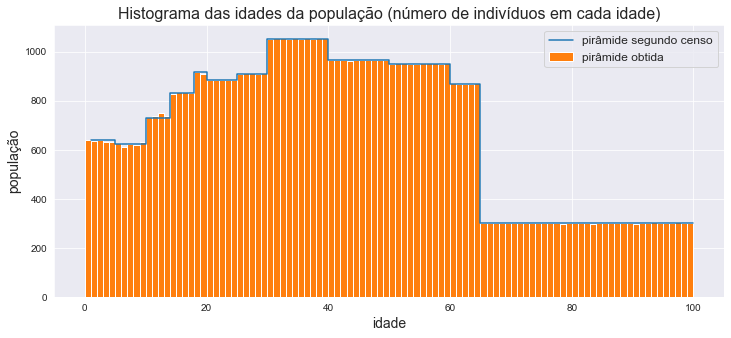

In [34]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(101)), color='tab:orange', label='pirâmide obtida')
plt.step([i+1 for i in idades],num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title('Histograma das idades da população (número de indivíduos em cada idade)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Aplicando em outras frações da população do Rio

- O código acima foi implementado no módulo de simulação em uma função chamada `gera_idades`.

    - Essa função recebe os argumentos

        - `num_pop`, 
        - `res_individuos`,
        - `idades_grupos`,
        - `idades_fracoes_grupos`.

    - Retornando

        - `pop_idades`.

- Vamos usar essa função para obter as idades em outras frações da população do Rio de Janeiro.

### Pirâmide populacional

Vamos considerar os seguintes dados da pirâmide populacional, como feito acima.

In [35]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100
print(f'Conferindo a soma das frações dos grupos de idades: {idades_fracoes_grupos.sum()}')

Conferindo a soma das frações dos grupos de idades: 1.0


#### Interpolando/extrapolando as frações das faixas da pirâmide populacional

In [36]:
idades_fracoes = list()
for j in range(len(idades_grupos)-1):
    idades_fracoes += (idades_grupos[j+1] - idades_grupos[j]) \
        * [idades_fracoes_grupos[j]/(idades_grupos[j+1]-idades_grupos[j])]

idades_fracoes += (idade_max - idades_grupos[-1]) \
        * [idades_fracoes_grupos[-1]/(idade_max-idades_grupos[-1])]

idades_fracoes = np.array(idades_fracoes)

#### Visualizando a pirâmide

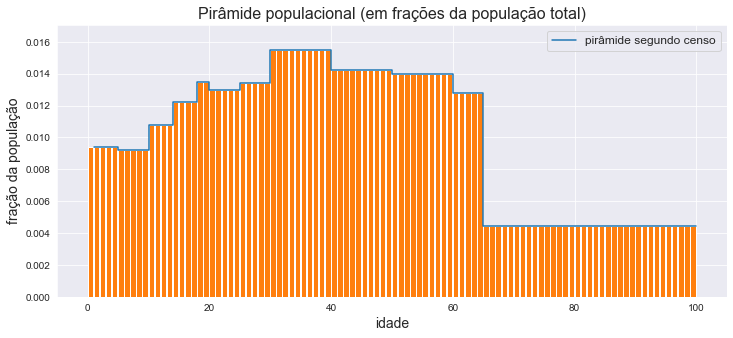

In [37]:
plt.figure(figsize=(12,5))
plt.bar(list(range(idade_max)), idades_fracoes, width=0.9, align = 'edge', color='tab:orange')
plt.step(list(range(1, idade_max+1)), idades_fracoes, label='pirâmide segundo censo')
plt.ylim([0,1.1*idades_fracoes.max()])
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Pirâmide populacional (em frações da população total)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por dez mil

In [38]:
pop_por_bloco = (landscan_rio/10000).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 297


#### Aloca população e residências

In [39]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 183 ms, sys: 2.93 ms, total: 186 ms
Wall time: 187 ms


#### Número de tamanhos de residências

In [40]:
num_tam_res = len(censo_residencial)

#### Gera idades

In [41]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos,
                                            idades_grupos, idades_fracoes_grupos, idade_max)

CPU times: user 3.34 ms, sys: 75 µs, total: 3.41 ms
Wall time: 3.93 ms


#### Visualizando a pirâmide populacional obtida

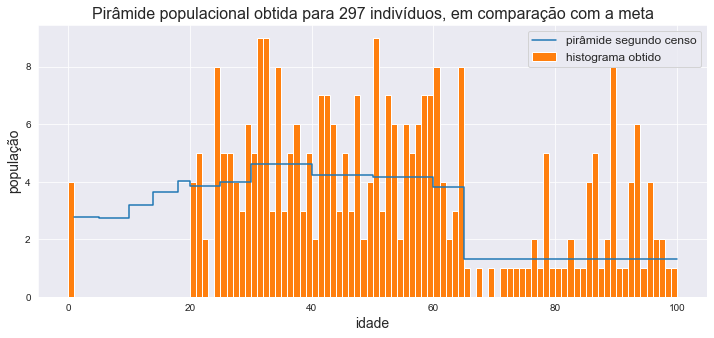

In [42]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='histograma obtido')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por mil

In [43]:
pop_por_bloco = (landscan_rio/1000).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 6333


#### Aloca população e residências

In [44]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 212 ms, sys: 2.86 ms, total: 215 ms
Wall time: 214 ms


#### Gera idades

In [45]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos,
                                            idades_grupos, idades_fracoes_grupos, idade_max)

CPU times: user 22.6 ms, sys: 1.04 ms, total: 23.6 ms
Wall time: 22.8 ms


#### Visualizando a pirâmide populacional obtida

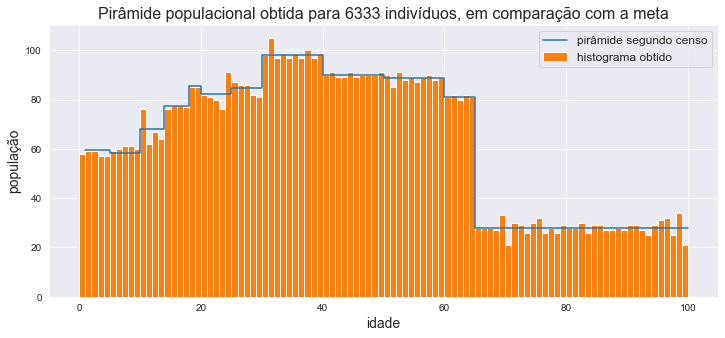

In [46]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='histograma obtido')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por cem

In [47]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 67973


#### Aloca população e residências

In [48]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 822 ms, sys: 6.43 ms, total: 829 ms
Wall time: 832 ms


#### Gera idades

In [49]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos,
                                            idades_grupos, idades_fracoes_grupos, idade_max)

CPU times: user 666 ms, sys: 13.9 ms, total: 680 ms
Wall time: 749 ms


#### Visualizando a pirâmide populacional obtida

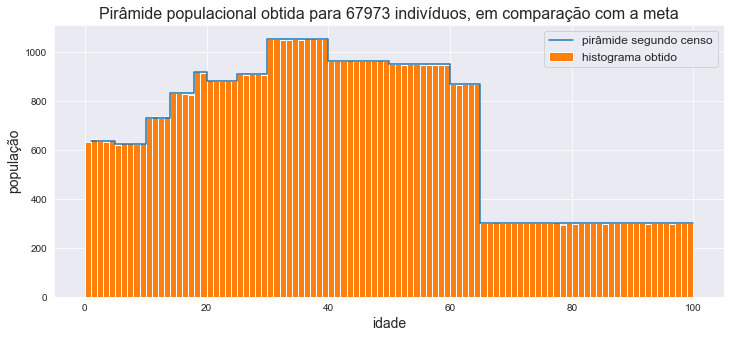

In [50]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='histograma obtido')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por dez

In [51]:
pop_por_bloco = (landscan_rio/10).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 685131


#### Aloca população e residências

In [52]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 54.4 s, sys: 3.24 s, total: 57.6 s
Wall time: 1min 1s


#### Gera idades

In [53]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos,
                                            idades_grupos, idades_fracoes_grupos, idade_max)

CPU times: user 1min 44s, sys: 898 ms, total: 1min 45s
Wall time: 1min 47s


#### Visualizando a pirâmide populacional obtida

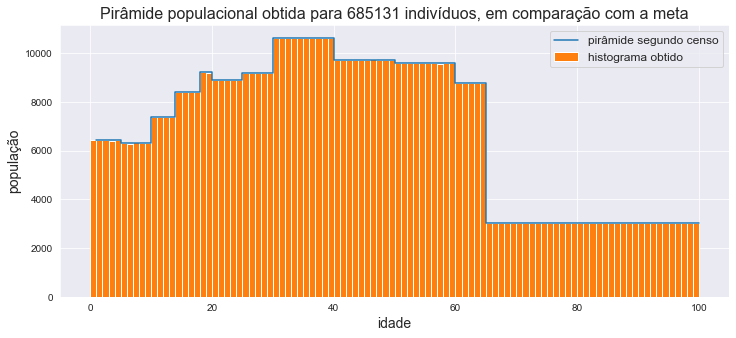

In [54]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='histograma obtido')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

<!--NAVIGATOR-->

---
[<- Modelos individuais - reformulação da implementação](16.00.Aula-Modelos_individuais_reformulacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário de múltiplos do Pop350: redes sociais ->](18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.ipynb)